In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob

cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

In [2]:
def convert_from_commas(df):
    for col in df.columns:
        df[col] = df[col].astype(str).map(lambda x: float(x.replace(',','.')))
    return df

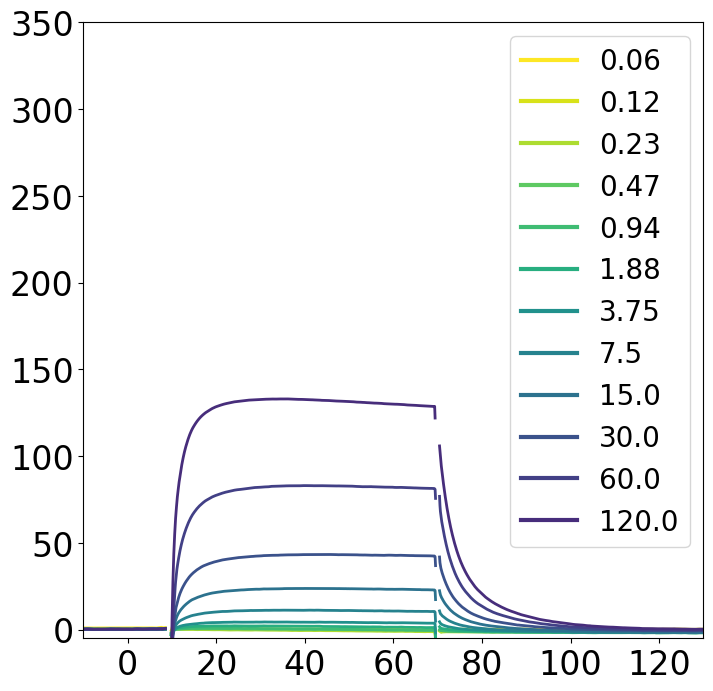

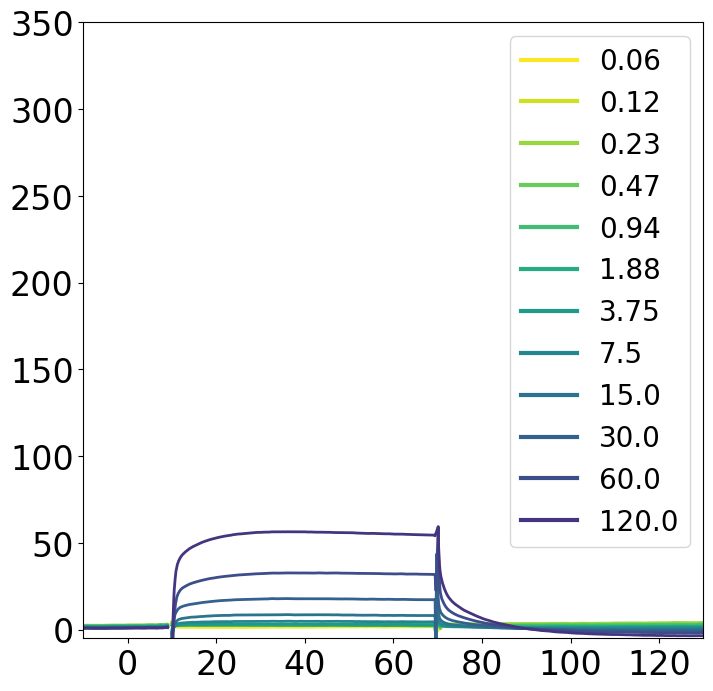

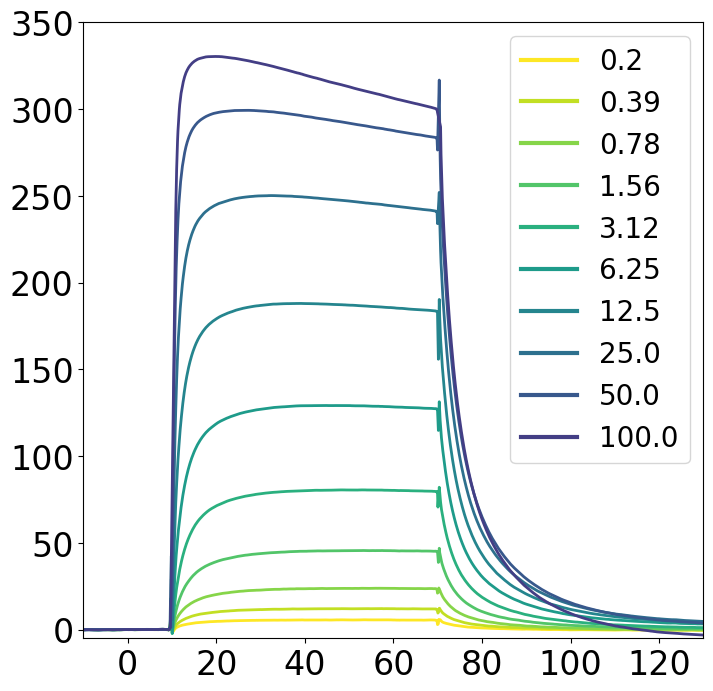

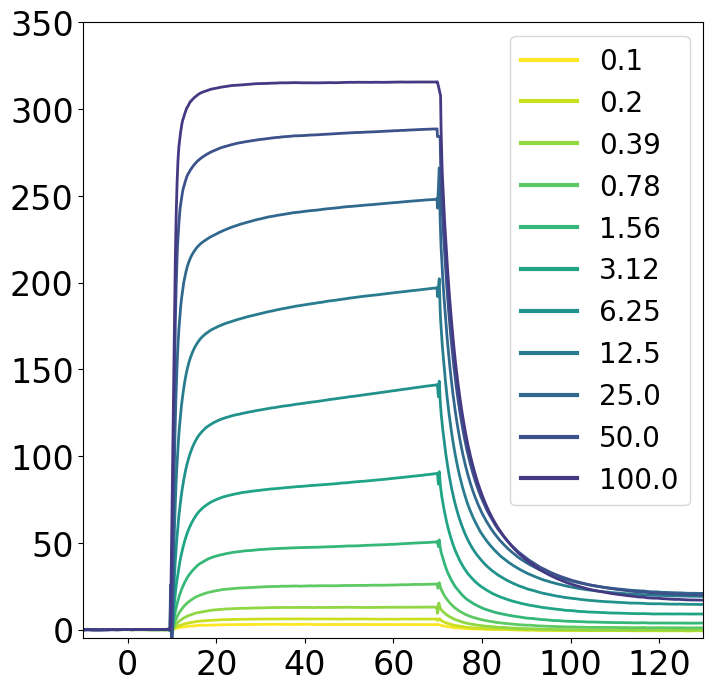

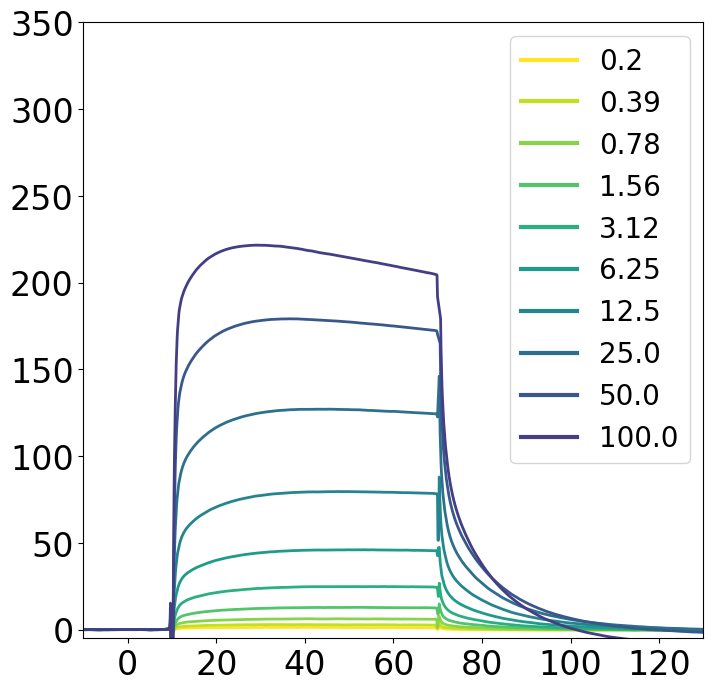

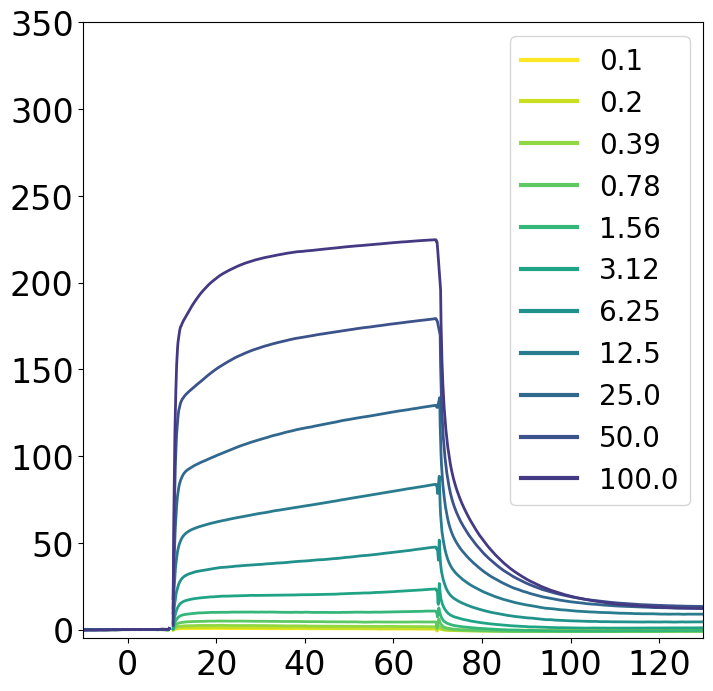

In [3]:
x_scale = 1e6

folders = {
    'soluble':'20250928_CSM8_A02_SPR_soluble/',
    'refolded':'../figure3_A02-characterization-yeast/20250928_CSM8_A02_SPR_refolded/'
}

reps = {
    'soluble':[''],
    'refolded':['-1','-2']
}

cycle_range = {
    ('soluble','9V',''):[15,30],
    ('soluble','9C',''):[2,12],
    ('refolded','9V','-1'):[15,26],
    ('refolded','9C','-1'):[3,14],
    ('refolded','9V','-2'):[15,26],
    ('refolded','9C','-2'):[3,14],
}

colors = {}
for kind in folders:
    for pep in ['9V','9C']:
        for rep in reps[kind]:
            colors[(kind,pep,rep)] = {}
            
            plt.figure(figsize=[8,8])
            sensogram = pd.read_csv(glob(f'{folders[kind]}*SMARTA2 {pep}{rep}*sens*.txt')[0],sep='\t')
            sensogram = convert_from_commas(sensogram)
            
            data_eq = pd.read_csv(glob(f'{folders[kind]}/*SMARTA2 {pep}{rep} kd*.txt')[0],sep='\t')
            data_eq = convert_from_commas(data_eq)
            data_eq = data_eq[~np.isnan(data_eq['X'])]
        
            if kind == 'refolded':
                x_low = -10
                x_high = 120
            else:
                x_low = 570
                x_high = 700
                # x_col = f'Cycle={cycle_range[(kind,pep,rep)][1]-1}_Fc=2-1_X'
                # y_col = f'Cycle={cycle_range[(kind,pep,rep)][1]-1}_Fc=2-1_Y'
                # win_min = 500
                # win_max = 600
            
                # sensogram_subset = sensogram[(sensogram[x_col] > win_min) & (sensogram[x_col] < win_max)]    
                # diff = np.abs(sensogram_subset[y_col].values[1:] - sensogram_subset[y_col].values[:-1])
                # is_max = diff == np.max(diff)
                # is_max = np.concatenate([is_max,[False]],axis=0)
                
                # x_low = sensogram_subset.loc[is_max,x_col].values[0] - 10
                # x_high = x_low + 120
        
            last_label = ''
            offset = 0
                
            for c,conc in enumerate(data_eq["X"]):
        
                label = round(conc*x_scale,2)
        
                if label==last_label:
                    offset += 1
                    continue
        
                if kind == 'refolded':
                    x_col = f'Cycle: {c+cycle_range[(kind,pep,rep)][0]}  SMARTA2-{pep}  {round(conc*1e9)} nM_X'
                    y_col = f'Cycle: {c+cycle_range[(kind,pep,rep)][0]}  SMARTA2-{pep}  {round(conc*1e9)} nM_Y'
                else:
                    x_col = f'Cycle={c+cycle_range[(kind,pep,rep)][0]}_Fc=2-1_X'
                    y_col = f'Cycle={c+cycle_range[(kind,pep,rep)][0]}_Fc=2-1_Y'

                diff = sensogram[y_col].values[1:] - sensogram[y_col].values[:-1]
                diff = np.concatenate([[0],diff],axis=0)
                big_change = np.abs(diff) > 30
                med_change = np.abs(diff) > 3
                sign_change = np.sign(diff[:-1]) != np.sign(diff[1:])
                sign_change = np.concatenate([sign_change,[False]],axis=0)
        
                bound_locs = (sensogram[x_col] > x_low + 20) & (sensogram[x_col] < x_low + 60)
                too_big = sensogram[y_col] > sensogram.loc[bound_locs,y_col].mean()+30
        
                spikes = big_change | (med_change & sign_change) | too_big
                sensogram.loc[spikes,x_col] = np.nan
                sensogram.loc[spikes,y_col] = np.nan
        
                color = cmap_seq((len(data_eq)+1-c)/(len(data_eq)+1))
                plt.plot(sensogram.loc[~spikes,x_col]-x_low,sensogram.loc[~spikes,y_col],color=color,label=label,linewidth=2)
        
                colors[(kind,pep,rep)][label] = color
        
                last_label = label
        
            plt.xlim([-10,x_high-x_low])
            plt.ylim([-5,350])
            leg = plt.legend(fontsize=20)
            for line in leg.get_lines():
                line.set_linewidth(3)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)
            plt.savefig(f'{kind}_{pep}{rep}_TCR_binding_kinetics.png',dpi=300,bbox_inches='tight')

In [4]:
def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

soluble 9V [9.79645743e+01 3.38404277e+08] [4.20766792e+00 8.39686912e+06]
soluble 9C [1.85531379e+02 2.18806115e+08] [1.57784865e+01 1.26868496e+07]
refolded 9V [1.14719113e+01 3.57868039e+08] [3.38839077e-01 3.31879628e+06]
refolded 9C [3.65181059e+01 3.03968297e+08] [5.95802932e-01 2.16286823e+06]


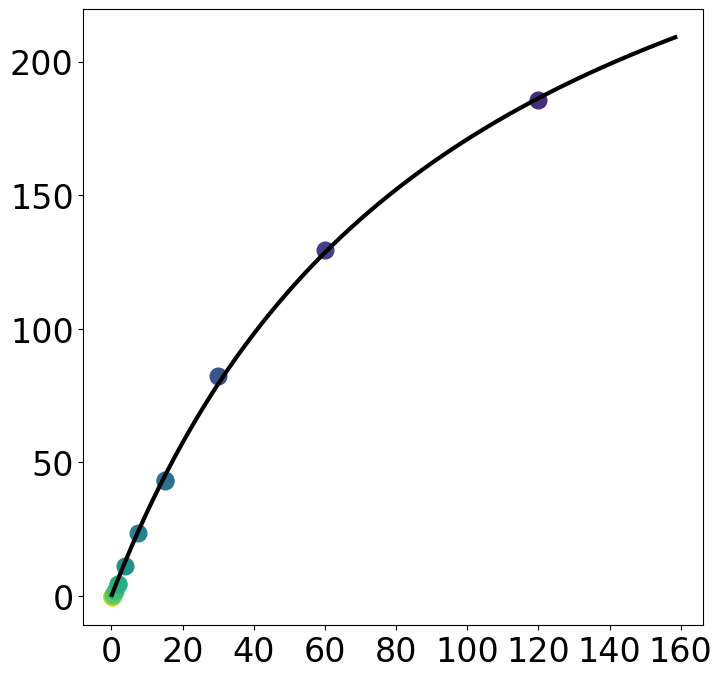

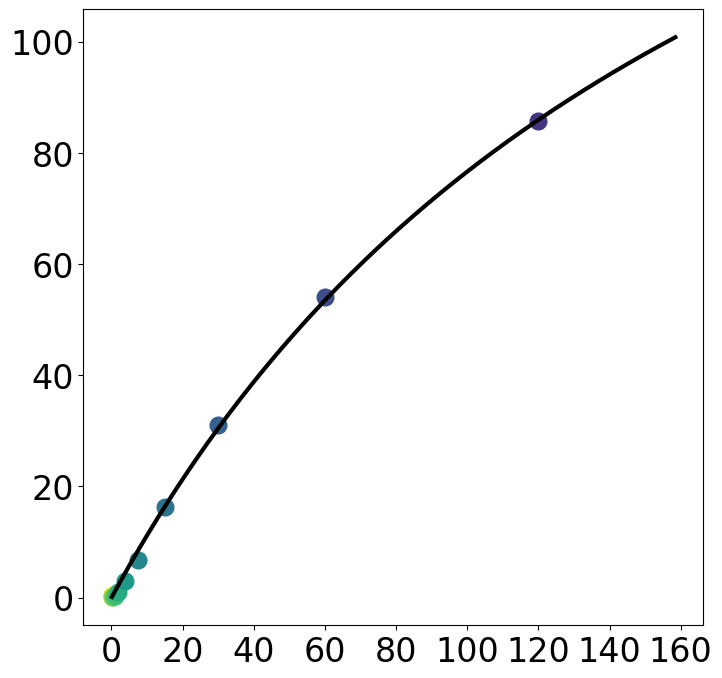

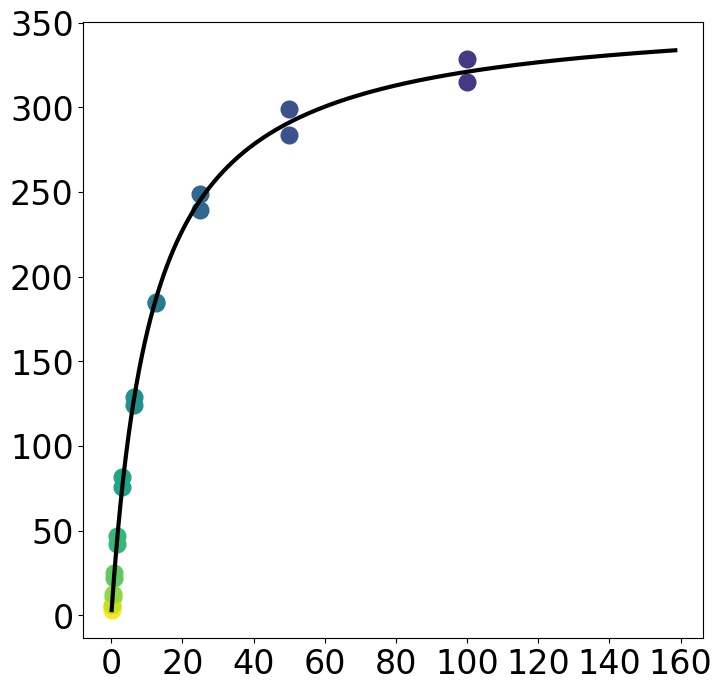

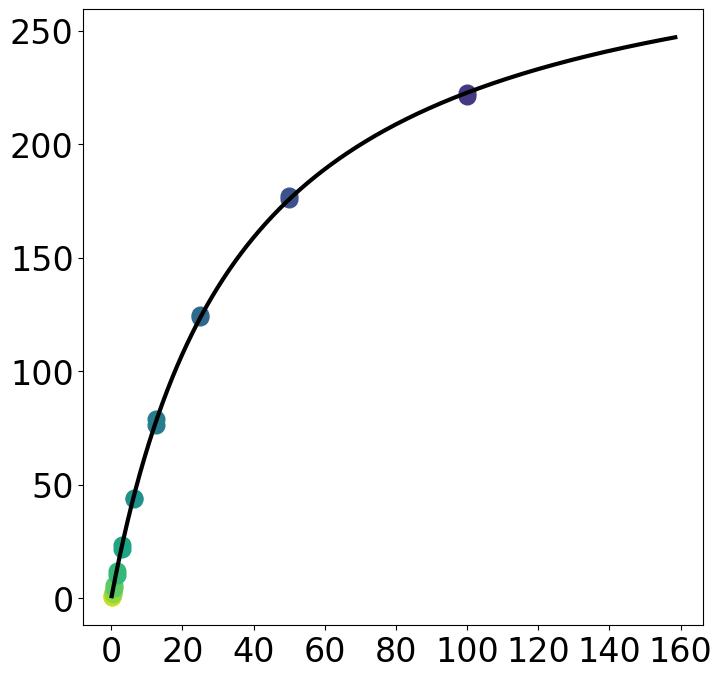

In [21]:
for kind in folders:
    for pep in ['9V','9C']:
        data_eq = []
        for rep in reps[kind]:
            rep_df = pd.read_csv(glob(f'{folders[kind]}/*SMARTA2 {pep}{rep} kd*.txt')[0],sep='\t')
            rep_df = convert_from_commas(rep_df)
            rep_df = rep_df[~np.isnan(rep_df['X'])]
            data_eq.append(rep_df)
        data_eq = pd.concat(data_eq,axis=0).reset_index()
    
        plt.figure(figsize=[8,8])
    
        params,cov = curve_fit(eqm_binding,data_eq["X"],data_eq["Y"],p0=[3e-5,300],bounds=[0,np.inf])
        
        x_fit = np.logspace(-7,-3.8,1000)
        y_fit = eqm_binding(x_fit,*params)
        
        print(kind, pep, params*1e6, np.sqrt(cov)[[0,1],[0,1]]*1e6)
    
        for i,conc in enumerate(data_eq['X']):
            plt.plot(data_eq.loc[i,'X']*x_scale,data_eq.loc[i,'Y'],'o',color=colors[(kind,pep,rep)][round(conc*x_scale,2)],markersize=12)
        
        plt.plot(x_fit*x_scale,y_fit,'-',color='k',linewidth=3,label=pep)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.savefig(f'{kind}_{pep}_TCR_binding_eqm.png',dpi=300,bbox_inches='tight')